In [15]:
# %matplotlib inline

In [16]:
import pandas as pd
import json
import numpy as np

In [17]:
from matplotlib import pyplot as plt

In [18]:
from matplotlib.patches import Circle, PathPatch
import mpl_toolkits.mplot3d.art3d as art3d

In [19]:
from matplotlib import rc
# rc('animation', html='html5')

In [20]:
data = json.load(open("data.json", "r"))

In [21]:
import datetime

In [22]:
headers = data[0]
raw = data[1:]
temp_list = []
date_list = []
for j in range(len(raw)):
    year = raw[j][0]
    for month in range(1, 13):
        date = datetime.datetime(year=int(year), month=month, day=1)
        val = raw[j][month]
        val = np.nan if val == "-" else float(val.replace(",", "."))
        date_list.append(date)
        temp_list.append(val)
df = pd.DataFrame(dict(temp=temp_list, date=date_list))
        

In [23]:
df.sort_values(by='date', inplace=True)

In [24]:
base = dict()

date = pd.DatetimeIndex(df.date)
for month in date.month.unique():
    base[month] = np.nanmean(df[date.month == month]["temp"].values[:25])

months = date.month.unique()
years = date.year.unique()

x = []
y = []
c = []
z = []
angles = dict()
max_length = 0.0
min_length = 10 #sum(base.values()) / 12.0
for year in years:
    for month in months:
        temp1 = df[(date.month == month)].set_index('date')['temp'].rolling(4).mean()
        
        temp = temp1[temp1.index.year == year].values[0]
        if pd.isna(temp):
            continue
#         print(temp1[temp1.index.year == year].values[0])
        ref_temp = base[month]
    #     cache[date.month] = temp
        r = min_length+(temp - ref_temp)*1.3
        phi = ((month-1)) / 12 * 2 * np.pi
        x.append(
            r * np.cos(phi)
        )
        angles[month] = phi
        y.append(r*np.sin(phi))
        z.append(year)
        c.append(r)
        max_length = max(max_length, r)


In [25]:
month_list = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]

In [26]:
max(years)

2018

<IPython.core.display.Javascript object>


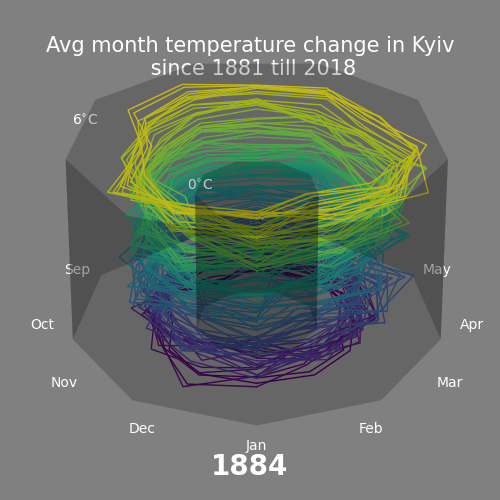

In [34]:
%matplotlib notebook
# cache = dict()
# x = []
# y = []
# z = []
# c = []
# for i, (temp, date) in enumerate(df.sort_values(by='date').values):
#     if pd.isna(temp):
#         continue
#     if date.month not in cache:
#         cache[date.month] = temp
#     ref_temp = cache[date.month]
# #     cache[date.month] = temp
#     r = 10 + temp - ref_temp
#     phi = (date.month % 12) / 12 * 2 * np.pi
#     x.append(
#         r * np.cos(phi)
#     )
#     y.append(r*np.sin(phi))
#     z.append(date.year)
#     c.append(r)

x = np.array(x)
y = np.array(y)
z = np.array(z)
c = np.array(c)
T = 1-np.linspace(0, 1.0, len(x))
# T = 1 - (c -c.min()) / (c.max() - c.min())
# fig, axs = plt.subplots(figsize=(15, 15))
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)#, projection='3d')
from matplotlib import cm
viridis = cm.get_cmap('viridis', len(x))
mapping = dict()

years = sorted(np.unique(z).tolist())
for year in years:
    mask = z == year
    
    i = np.where(mask)[0][0]
    end = np.where(mask)[0][-1]+2
    mask = slice(i, end)
#     ax.plot(x[mask], y[mask],  color=(1.0 - T[i], 0.5, T[i]), label=year)
    data = (x[mask], y[mask], z[mask])
    color=(1.0 - T[i], 0.5, T[i])
    color = viridis(i)
    kwargs = dict(color=color, label=year, linewidth=1)#, cmap='viridus')
    mapping[year] = (i, data, kwargs)

#ax.plot(x, y,  color=(1.0 - T[i], 0.5, T[i]), label=year)
# for i in range(0, len(x)-2, 1):
#     sl = slice(i, i+2)
#     ax.plot(x[sl], y[sl], z[sl], color=(1.0 - T[i], 0.5, T[i]))
    
# ax.set_aspect('equal')
# axs.legend()
from matplotlib.animation import FuncAnimation
# fig, ax = plt.subplots(projection='3d')
#figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

import mpl_toolkits.mplot3d.axes3d as p3
fig = plt.figure(figsize=(5, 5))
ax = p3.Axes3D(fig)
# ax = fig.add_subplot(111)

title = "Avg month temperature change in Kyiv\n since 1881 till 2018"
ax.text2D(0.5, 0.85, title, transform=ax.transAxes, fontsize=15, ha="center", color="white")
xdata, ydata = [], []
# ln, = plt.plot([], [], )


for text, phi in angles.items():
    # (1, 1, 0)
    length = max_length+3
    text = month_list[text-1]
    ax.text(length*np.cos(phi), length*np.sin(phi), 1880.0, text, zorder=1, color="white", ha="center")




lines = [ax.plot(np.array([0.0]), np.array([0.0]), np.array([min(years)]), **mapping[year][2])[0] for year in years]
x_scale=1
y_scale=1
z_scale=1

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
    return np.dot(p3.Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj
ax._axis3don = False
ax.set_facecolor('grey')

def init():
    ax.set_zlim3d(1870, 2021)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(False)
#     ax.set_xlim3d(-15, 15)
#     ax.set_ylim3d(-15, 15)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    return lines

speed = 4

def update(frame, years, mapping, lines):
    frame = frame* 4
#     print("HERE")
    # elev=10., 
    ax.view_init(azim=-frame/4.0)
    for i, year in enumerate(years):
        start, data = mapping[year][:2]
        if frame >= start:
            year_text.set_text(year)
        if frame <= start:
            continue
        lines[i].set_data(
            data[0][:frame - start],
            data[1][:frame - start],
            #data[2][:frame - start]
        )
        lines[i].set_3d_properties(data[2][:frame - start])
    return lines
_ = init()


def plot_cylinder():
    x=np.linspace(-1, 1, 100)
    z=np.linspace(min(years), max(years), 100)
    Xc, Zc=np.meshgrid(x, z)
    Yc = np.sqrt(1-Xc**2)

    # Draw parameters
    rstride = 20
    cstride = 10
    ax.plot_surface(Xc*max_length, Yc*max_length, Zc, alpha=0.2, rstride=rstride, cstride=cstride, color="grey")
    ax.plot_surface(Xc*max_length, -Yc*max_length, Zc, alpha=0.2, rstride=rstride, cstride=cstride, color="grey")
    
def cylinder2():
    def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
        z = np.linspace(0, height_z, 10)
        theta = np.linspace(0, 2*np.pi, 10)
        theta_grid, z_grid=np.meshgrid(theta, z)
        x_grid = radius*np.cos(theta_grid) + center_x
        y_grid = radius*np.sin(theta_grid) + center_y
        return x_grid,y_grid,z_grid
    Xc,Yc,Zc = data_for_cylinder_along_z(0.0,0.0,max_length,max(years)-min(years))
    ax.plot_surface(Xc, Yc, min(years)+Zc+1, alpha=0.2, color="black", zorder=2)
    Xc,Yc,Zc = data_for_cylinder_along_z(0.0,0.0,6.0,(max(years)-min(years))*0.75)
    ax.plot_surface(Xc, Yc, min(years)+Zc+1, alpha=0.2, color="black", zorder=2)
    
def add_circle(r, color, zorder=1, alpha=0.7):
    p = Circle((0.0, 0.0), r, zorder=zorder, alpha=alpha, color=color)
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=min(years)-3, zdir="z")#, zorder=1)
cylinder2()

year_text = ax.text2D(0.5, 0.05, "2020", transform=ax.transAxes, fontsize=20, ha="center", color="white", fontweight='bold')
ax.text2D(0.17, 0.75, "$" + str(int((max_length-min_length)/1.3))+ "^{\circ}$C",transform=ax.transAxes, color="white", ha="center", )
ax.text2D(0.4, 0.62, "$0^{\circ}$C",transform=ax.transAxes, color="white", ha="center", zorder=3)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ani = FuncAnimation(fig, update, len(x)//speed+20, fargs=(years, mapping, lines),
                    blit=False, interval=1)

# ani.save('animation2.gif', writer='imagemagick', fps=100)#, fps=60)
ani.save('plot.gif', fps=30)
# plt.show()
# plt.close()






In [28]:
|

SyntaxError: invalid syntax (<ipython-input-28-4b37ef281455>, line 1)